In [30]:
import os
import pandas as pd
import re
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
# Folder path to your CSV files
folder_path = './Data/'
min_length = 252*10
save_path = "./Clean/clean-huf-spy-10.csv"
file_names = os.listdir(folder_path)
dfs = []
for file_name in file_names:
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='ISO-8859-2') as file:
            content = file.read()
        content = re.sub(r'\"(.*?)\"', lambda x: x.group(0).replace(',', '.'), content)
        cleaned_content = StringIO(content)
        df = pd.read_csv(cleaned_content, skiprows=17, encoding='ISO-8859-2')
        if len(df) > min_length:
            df = df[['Dátum', 'Árfolyam']]
            df['Dátum'] = pd.to_datetime(df['Dátum'], format='%Y/%m/%d')
            df.set_index('Dátum')
            df = df.rename(columns={'Árfolyam': file_name.replace('.csv', '')})
            dfs.append(df)
            if "Citadella_Származtatott" == file_name.replace('.csv', ''):
                print("Citadella", df['Citadella_Származtatott'][df["Dátum"] == "2018-03-08"])
merged_df = dfs[0]

for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, left_on='Dátum', right_on='Dátum', how='left')
merged_df.set_index('Dátum')
# merged_df = pd.concat(dfs, axis=1)
# merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
print("Citadella", merged_df[merged_df["Dátum"] == "2018-03-08"]['Citadella_Származtatott'])

# print(merged_df)
df_trimmed = merged_df.dropna()
print("Citadella", df_trimmed['Citadella_Származtatott'][df_trimmed["Dátum"] == "2018-03-08"])


Citadella 1610    2.176651
Name: Citadella_Származtatott, dtype: float64
Citadella 1623    2.176651
Name: Citadella_Származtatott, dtype: float64
Citadella 1623    2.176651
Name: Citadella_Származtatott, dtype: float64


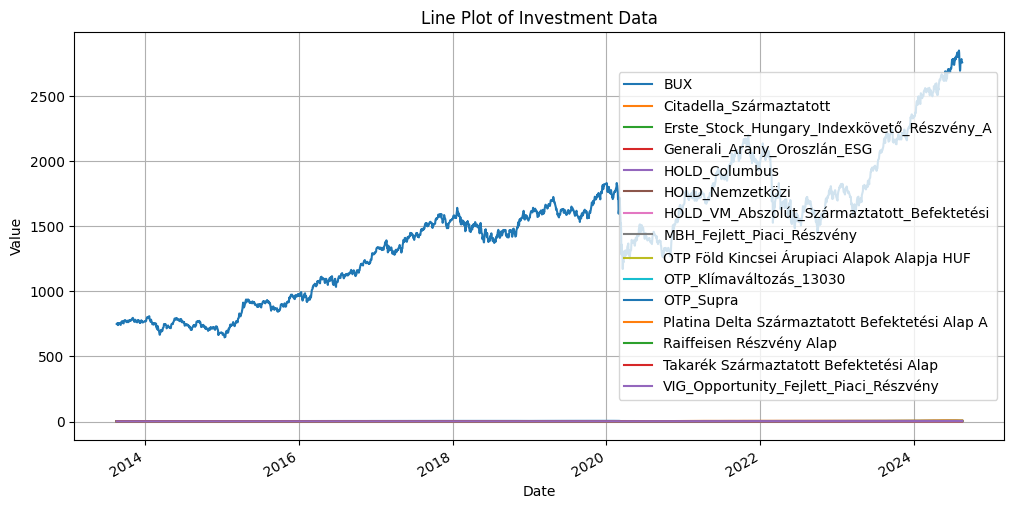

In [31]:
df_trimmed.set_index('Dátum').plot(kind='line', figsize=(12, 6))
plt.title('Line Plot of Investment Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [32]:
def load_yfinance_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data
last_date = df_trimmed['Dátum'].iloc[-1]


In [33]:
def load_yfinance_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

def download_tickers_data(tickers, start_date, end_date):
    combined_df = pd.DataFrame()  # Initialize an empty DataFrame
    for ticker in tickers:
        ticker_data = pd.DataFrame(load_yfinance_data(ticker, start_date, end_date))
        ticker_data.reset_index(inplace=True)
        ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])
        ticker_data.rename(columns={'Adj Close': ticker}, inplace=True)
        
        if combined_df.empty:
            combined_df = ticker_data[['Date', ticker]]  # Initialize combined_df with the first ticker's data
        else:
            combined_df = pd.merge(combined_df, ticker_data[['Date', ticker]], on='Date', how='outer')
    
    return combined_df
tickers = ['SPY', 'QQQ', 'VGT','BRK-B', 'USDHUF=X']  # Example list of tickers
start_date = last_date
end_date = '2024-08-15'
merged_data = download_tickers_data(tickers, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [34]:
df_trimmed['Dátum'] = pd.to_datetime(df_trimmed['Dátum'])
df_combined = pd.merge(df_trimmed, merged_data, left_on='Dátum', right_on='Date', how='left')
df_combined = df_combined.drop(columns=['Date'])

for ticker in tickers:
    if ticker=='USDHUF=X':
        continue
    df_combined[ticker] = df_combined[ticker]*df_combined['USDHUF=X']
df_combined_cleaned = df_combined.dropna()
print(df_combined_cleaned.isna().any())


Dátum                                             False
BUX                                               False
Citadella_Származtatott                           False
Erste_Stock_Hungary_Indexkövető_Részvény_A        False
Generali_Arany_Oroszlán_ESG                       False
HOLD_Columbus                                     False
HOLD_Nemzetközi                                   False
HOLD_VM_Abszolút_Származtatott_Befektetési        False
MBH_Fejlett_Piaci_Részvény                        False
OTP Föld Kincsei Árupiaci Alapok Alapja HUF       False
OTP_Klímaváltozás_13030                           False
OTP_Supra                                         False
Platina Delta Származtatott Befektetési Alap A    False
Raiffeisen Részvény Alap                          False
Takarék Származtatott Befektetési Alap            False
VIG_Opportunity_Fejlett_Piaci_Részvény            False
SPY                                               False
QQQ                                             

C:\Users\takat\AppData\Local\Temp\ipykernel_36152\1564557036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['Dátum'] = pd.to_datetime(df_trimmed['Dátum'])


In [35]:
df_combined_cleaned.to_csv(save_path)